In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


/home/asimovws/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


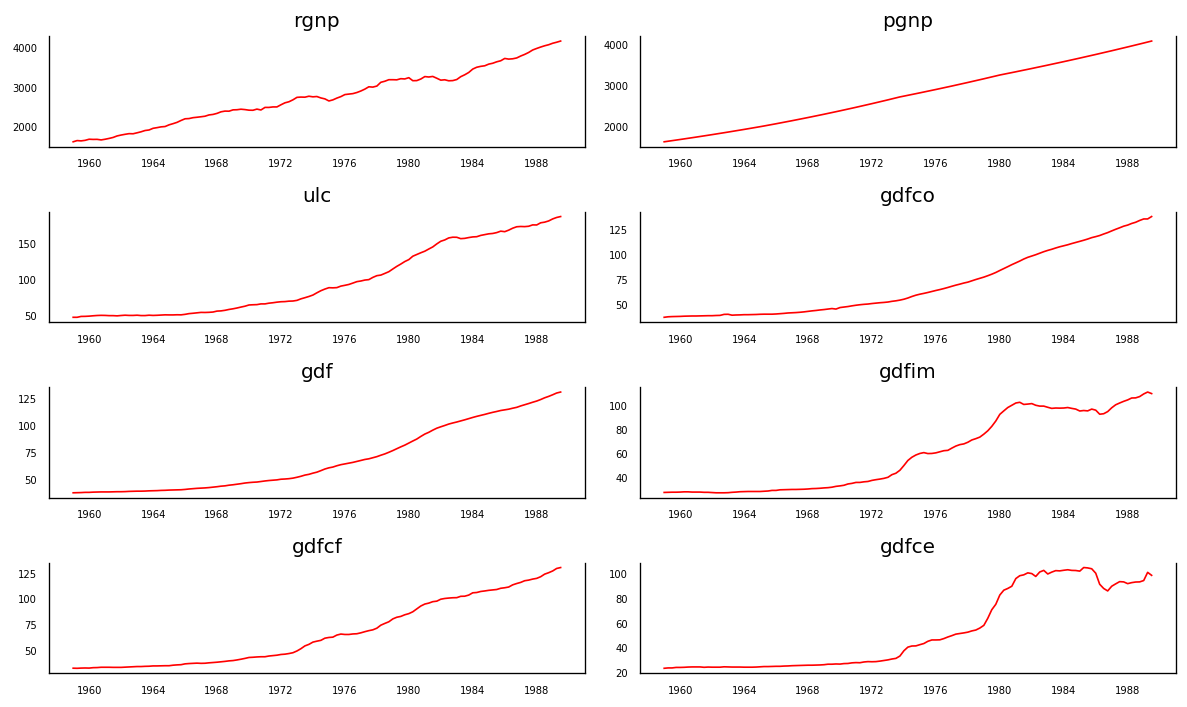

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)     

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


In [23]:
def adjust(val, length= 6): return str(val).ljust(length)


In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [11]:
df_differenced = df_train.diff().dropna()

In [12]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [13]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [15]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0123
 No. Lags Chosen       = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9813
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [16]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450668
BIC :  0.34118471465888334
FPE :  0.2552682517347197
HQIC:  -0.6741331335699559 

Lag Order = 2
AIC :  -1.6212373944478244
BIC :  1.6249432095295844
FPE :  0.20113494371371382
HQIC:  -0.30362888267959276 

Lag Order = 3
AIC :  -1.76580083870128
BIC :  3.0345473163767824
FPE :  0.18125103746164348
HQIC:  0.18239143783963208 

Lag Order = 4
AIC :  -2.000735164470317
BIC :  4.371215137654088
FPE :  0.1555696652148111
HQIC:  0.5849359332771078 

Lag Order = 5
AIC :  -1.9619535608363954
BIC :  5.9993645622420955
FPE :  0.18692794389114886
HQIC:  1.268206331178333 

Lag Order = 6
AIC :  -2.3303386524829053
BIC :  7.2384526890885805
FPE :  0.16380374017443664
HQIC:  1.5514371669548073 

Lag Order = 7
AIC :  -2.5923313523471236
BIC :  8.6023872549378
FPE :  0.1823868583715424
HQIC:  1.9483069621146605 

Lag Order = 8
AIC :  -3.317261976458207
BIC :  9.522195810323028
FPE :  0.1557316324820906
HQIC:  1.8896071386220967 

Lag Order = 9
AIC :  -4.804763125

/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [17]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Jan, 2020
Time:                     17:42:53
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

In [26]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rgnp   : 2.09
pgnp   : 2.02
ulc    : 2.17
gdfco  : 2.05
gdf    : 2.25
gdfim  : 1.99
gdfcf  : 2.2
gdfce  : 2.17


In [27]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [28]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [34]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


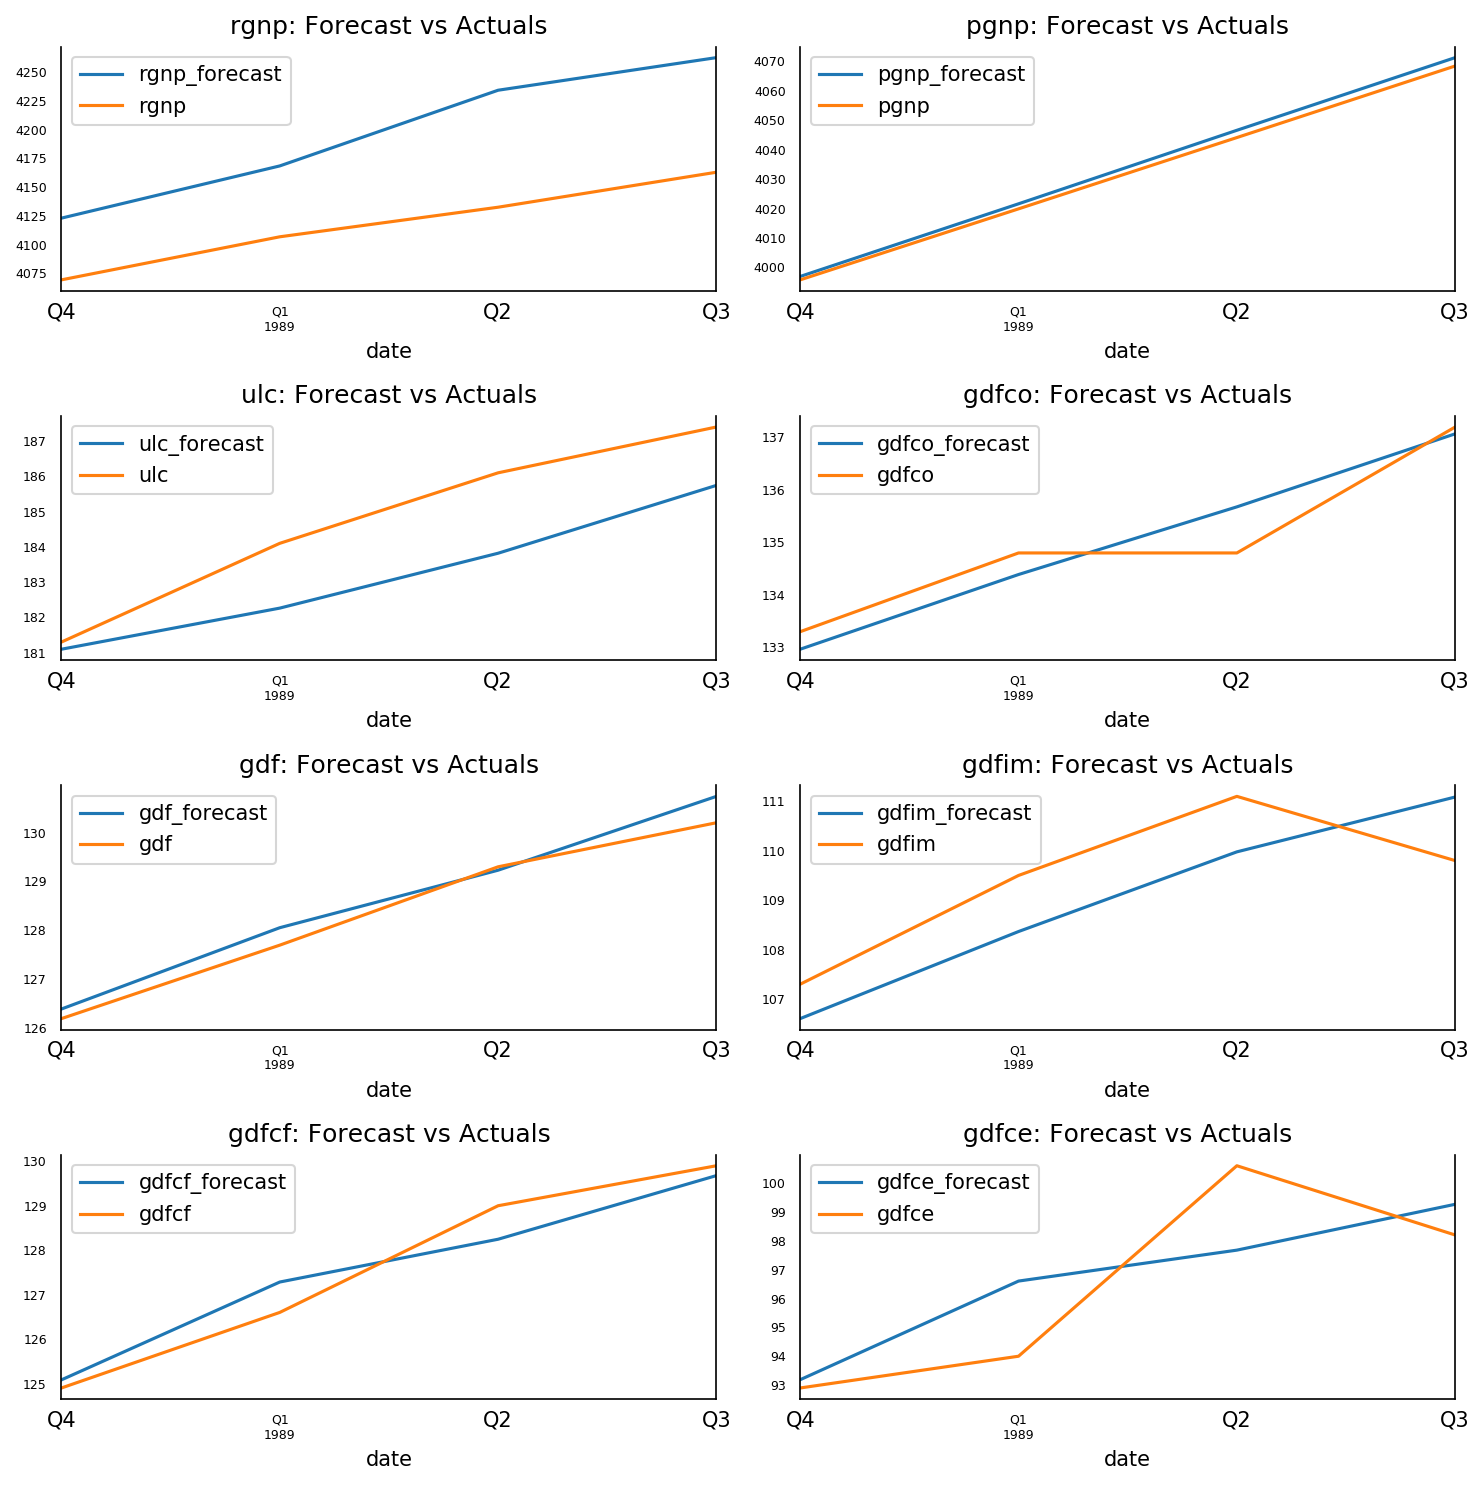

In [35]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [36]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0192
me     :  79.1031
mae    :  79.1031
mpe    :  0.0192
rmse   :  82.0245
corr   :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape   :  0.0005
me     :  2.0432
mae    :  2.0432
mpe    :  0.0005
rmse   :  2.146
corr   :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape   :  0.0081
me     :  -1.4947
mae    :  1.4947
mpe    :  -0.0081
rmse   :  1.6856
corr   :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape   :  0.0033
me     :  0.0007
mae    :  0.4384
mpe    :  0.0
rmse   :  0.5169
corr   :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape   :  0.0023
me     :  0.2554
mae    :  0.29
mpe    :  0.002
rmse   :  0.3392
corr   :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape   :  0.0097
me     :  -0.4166
mae    :  1.06
mpe    :  -0.0038
rmse   :  1.0826
corr   :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape   :  0.0036
me     :  -0.0271
mae    :  0.4604
mpe    :  -0.0002
rmse   :  0.5286
corr   :  

In [37]:
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [38]:
df[0:-4]

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1987-07-01,3872.8,3877.7,173.9,126.0,119.6,101.9,117.7,93.1
1987-10-01,3935.6,3901.0,175.8,127.6,120.8,103.3,118.7,92.9
1988-01-01,3974.8,3924.5,175.7,128.7,121.9,104.5,119.4,91.5


In [39]:
df[-4:]

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2
